In [1]:
#import numpy as np
import matplotlib.pyplot as plt
#import pyedflib
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging
import os
import numpy as np

In [2]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [3]:
path2pt = '/mnt/speech6/bagher/nemati/pytorch_datasets/chb_mit_raw'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [4]:
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [5]:
files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [6]:
len(files_train), len(files_test)

(549, 137)

In [7]:
mne.set_log_level(verbose='ERROR')

In [8]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 30
time_step = 4

root = "/mnt/speech6/bagher/nemati/pytorch_datasets"

if os.path.exists(f'{root}/signal_samples_{time_window}.npy')&os.path.exists(f'{root}/is_sz_{time_window}.npy'):
    array_signals=np.load(f'{root}/signal_samples_{time_window}.npy')
    array_is_sz=np.load(f'{root}/is_sz_{time_window}.npy')
else:
    p = 0.01  
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs # 8*256
            step = time_step*fs # 4*256
            
            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times # 100000*256
            
            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
        
        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()
    
    np.save(f'{root}/signal_samples_{time_window}', array_signals)
    np.save(f'{root}/is_sz_{time_window}', array_is_sz)

In [9]:
array_signals.shape

(10357, 18, 7680)

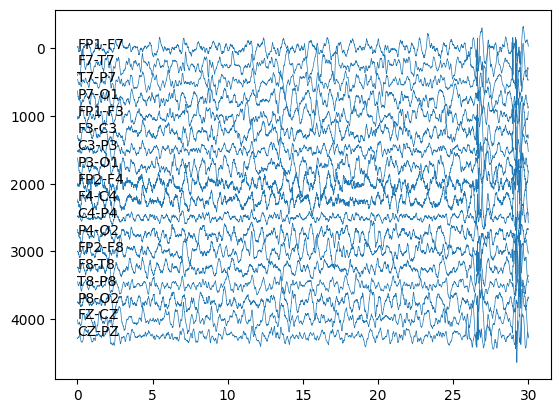

In [10]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 256

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()


In [11]:
# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 10357
Number of signals with seizures: 3439
Ratio of signals with seizures: 0.332


In [12]:
from sklearn import model_selection

# CNN will be used. Channel dimension is added.
array_signals = array_signals[:, :, :, np.newaxis]

print(array_signals.shape)

# splitting training data into training & validation data.

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

del array_signals, array_is_sz

print(X_train.shape)

(10357, 18, 7680, 1)
(7249, 18, 7680, 1)


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]),
    layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'),
    layers.MaxPooling2D((1, 2)),

    layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'),
    layers.MaxPooling2D((1, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(2, activation='softmax'),
])

model.summary()

2024-08-21 10:55:57.341664: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 10:55:57.354962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 10:55:57.373050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 10:55:57.373071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 10:55:57.384955: I tensorflow/core/platform/cpu_feature_gua

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 7680, 64)   │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 3840, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 18, 1920, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 1920, 128)  │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 960, 128)   │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 480, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 480, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 240, 256)    │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 120, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,910,722 (7.29 MB)

 Trainable params: 1,910,722 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)
hist = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64, callbacks=[es])

Epoch 1/200


I0000 00:00:1724262965.109175 2654626 service.cc:145] XLA service 0x76539c002840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724262965.109299 2654626 service.cc:153]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
I0000 00:00:1724262965.109306 2654626 service.cc:153]   StreamExecutor device (1): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-08-21 10:56:05.215222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 10:56:05.457148: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-08-21 10:56:22.121477: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,256,10,480]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,256,9,240]{3,2,1,0}, f32[256,256,4,4]{3,2,1,0}), window={size=4x4 stride=1x2 pad=1_1x1_1}, d

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.6059 - loss: 0.7064

2024-08-21 10:57:57.011390: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[17,256,10,480]{3,2,1,0}, u8[0]{0}) custom-call(f32[17,256,9,240]{3,2,1,0}, f32[256,256,4,4]{3,2,1,0}), window={size=4x4 stride=1x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-21 10:57:57.035808: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.024562712s
Trying algorithm eng0{} for conv (f32[17,256,10,480]{3,2,1,0}, u8[0]{0}) custom-call(f32[17,256,9,240]{3,2,1,0}, f32[256,256,4,4]{3,2,1,0}), window={size=4x4 stride=1x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6061 - loss: 0.7063

2024-08-21 10:58:17.526592: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[36,64,18,3840]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,64,19,7682]{3,2,1,0}, f32[64,64,2,4]{3,2,1,0}, f32[64]{0}), window={size=2x4 stride=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-21 10:58:17.593891: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.067449684s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[36,64,18,3840]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,64,19,7682]{3,2,1,0}, f32[64,64,2,4]{3,2,1,0}, f32[64]{0}), window={size=2x4 stride=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operatio

114/114 ━━━━━━━━━━━━━━━━━━━━ 143s 845ms/step - accuracy: 0.6064 - loss: 0.7061 - val_accuracy: 0.6721 - val_loss: 0.6436
Epoch 2/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 629ms/step - accuracy: 0.6648 - loss: 0.6545 - val_accuracy: 0.7323 - val_loss: 0.5672
Epoch 3/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 636ms/step - accuracy: 0.7155 - loss: 0.5823 - val_accuracy: 0.7381 - val_loss: 0.5320
Epoch 4/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 634ms/step - accuracy: 0.7335 - loss: 0.5267 - val_accuracy: 0.7651 - val_loss: 0.4868
Epoch 5/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 70s 616ms/step - accuracy: 0.7701 - loss: 0.4927 - val_accuracy: 0.8089 - val_loss: 0.4043
Epoch 6/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 69s 605ms/step - accuracy: 0.8170 - loss: 0.4044 - val_accuracy: 0.8417 - val_loss: 0.4118
Epoch 7/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 68s 601ms/step - accuracy: 0.8225 - loss: 0.3981 - val_accuracy: 0.8745 - val_loss: 0.3038
Epoch 8/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 631ms/step - accuracy: 0.8622 - loss: 0.34

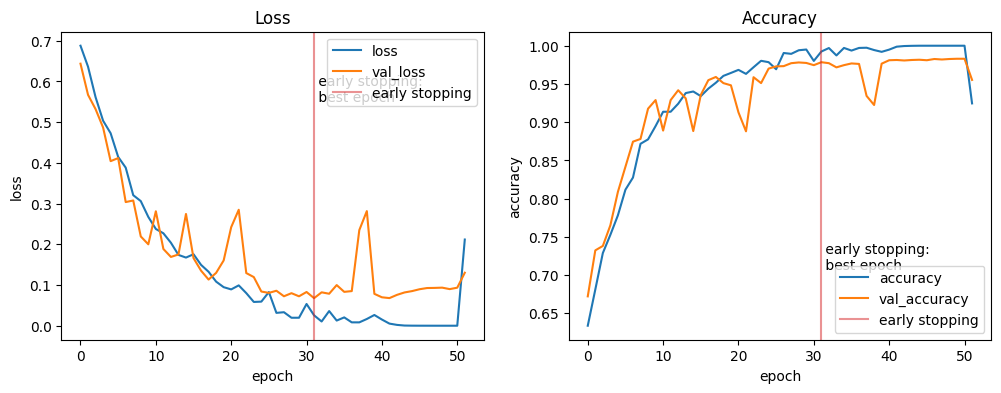

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [16]:
from sklearn import metrics

y_true = y_val
y_pred = tf.argmax(model.predict(X_val), axis=1)

print(metrics.classification_report(y_true, y_pred, digits=4))

98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step
              precision    recall  f1-score   support

       False     0.9818    0.9860    0.9839      2076
        True     0.9717    0.9632    0.9674      1032

    accuracy                         0.9784      3108
   macro avg     0.9767    0.9746    0.9756      3108
weighted avg     0.9784    0.9784    0.9784      3108

